<a href="https://colab.research.google.com/github/faizankshaikh/HomMul/blob/main/experiments/trial1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Experiments with Self-Playing Deep Reinforcement Learning


In [1]:
#@title Required installation
# !pip install -q black gymnasium pettingzoo==1.22.3 tianshou
# !git clone https://github.com/faizankshaikh/HomMul.git

In [2]:
#@title Change working path
%cd HomMul/

/content/HomMul


In [3]:
#@title Import libraries and modules
%load_ext tensorboard

import os
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from hommul.envs.hommul_v0 import HomMul

from torch.optim import Adam

from tianshou.data import Batch
from tianshou.utils.net.common import Net
from tianshou.utils import TensorboardLogger
from tianshou.trainer import offpolicy_trainer
from tianshou.data import Collector, VectorReplayBuffer
from tianshou.env import DummyVectorEnv, PettingZooEnv
from tianshou.policy import BasePolicy, DQNPolicy, MultiAgentPolicyManager

from pettingzoo.utils import parallel_to_aec

from torch.utils.tensorboard import SummaryWriter

In [4]:
#@title Setup Gymnasium environment
env = HomMul()
original_env = HomMul(render_mode="human")

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [5]:
#@title Example of gameplay
episodes = 2

for episode in range(episodes):
    print(f"Episode #{episode+1}")
    print("=" * 10)
    obs = original_env.reset()
    print()

    while original_env.agents:
        acts = {
            "player1": np.random.choice([0, 1]),
            "player2": np.random.choice([0, 1])
        }
        print(f"--Action taken by player 1: {original_env.action_dict[acts['player1']]}")
        print(f"--Action taken by player 2: {original_env.action_dict[acts['player2']]}")
        print()

        obs, rews, terms, truncs, infos = original_env.step(acts)
        print()

Episode #1
--Days left: 1
--Current life of agent 1: 1
--Current life of agent 2: 2
--Probability of payoff for agent 1: 0.4
--Probability of payoff for agent 2: 0.4

--Action taken by player 1: wait
--Action taken by player 2: wait

--Days left: 0
--Current life of agent 1: 0
--Current life of agent 2: 1
--Probability of payoff for agent 1: 0.4
--Probability of payoff for agent 2: 0.4
--Previous action of agent 1: wait
--Previous action of agent 2: wait

Episode #2
--Days left: 1
--Current life of agent 1: 1
--Current life of agent 2: 2
--Probability of payoff for agent 1: 0.2
--Probability of payoff for agent 2: 0.2

--Action taken by player 1: play
--Action taken by player 2: play

--Days left: 0
--Current life of agent 1: 0
--Current life of agent 2: 0
--Probability of payoff for agent 1: 0.2
--Probability of payoff for agent 2: 0.2
--Previous action of agent 1: play
--Previous action of agent 2: play



## Heuristics Benchmarking


death rate of player2: 0.351
ratio of death rate of player2 with respect to player1: 0.900


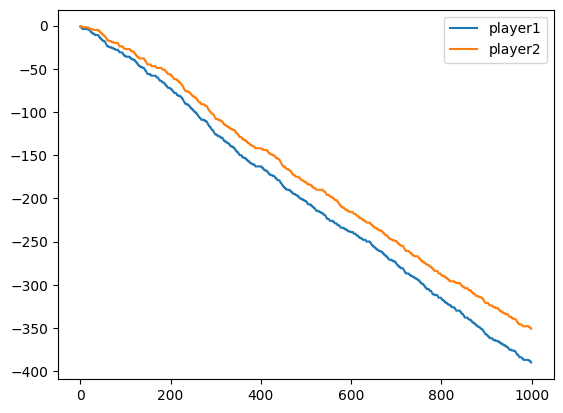

In [6]:
#@title Case - both always play
episodes = 1000

episode_rews = []

for _ in range(episodes):

    obs = env.reset()
    while env.agents:
        acts = {
            "player1": 1,
            "player2": 1
        }

        obs, rews, terms, truncs, infos = env.step(acts)
        # print(obs, rews)

    episode_rews.append([rews['player1'], rews['player2']])

arr = np.array(episode_rews)
death_rates = np.sum(arr, axis=0) / np.sum(arr, axis=0)[0]
print(f"death rate of player2: {(np.sum(arr, axis=0) / arr.shape[0])[-1] * -1:.3f}")
print(f"ratio of death rate of player2 with respect to player1: {death_rates[-1]:.3f}")
plt.plot(arr.cumsum(axis=0))
plt.legend(("player1", "player2"))
plt.show()

death rate of player2: 0.426
ratio of death rate of player2 with respect to player1: 0.683


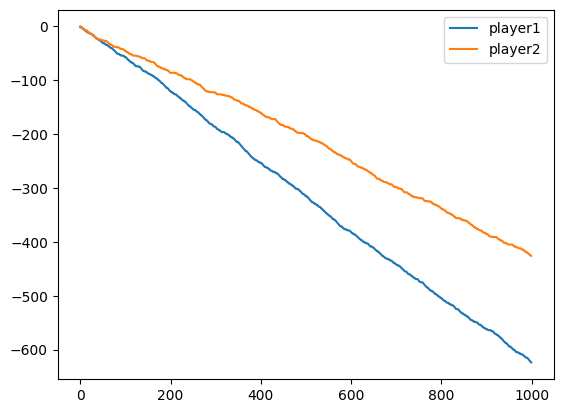

In [7]:
#@title Case - both always wait
episodes = 1000

episode_rews = []

for _ in range(episodes):

    obs = env.reset()
    while env.agents:
        acts = {
            "player1": 0,
            "player2": 0
        }

        obs, rews, terms, truncs, infos = env.step(acts)
        # print(obs, rews)

    episode_rews.append([rews['player1'], rews['player2']])

arr = np.array(episode_rews)
death_rates = np.sum(arr, axis=0) / np.sum(arr, axis=0)[0]
print(f"death rate of player2: {(np.sum(arr, axis=0) / arr.shape[0])[-1] * -1:.3f}")
print(f"ratio of death rate of player2 with respect to player1: {death_rates[-1]:.3f}")
plt.plot(arr.cumsum(axis=0))
plt.legend(("player1", "player2"))
plt.show()

death rate of player2: 0.566
ratio of death rate of player2 with respect to player1: 0.906


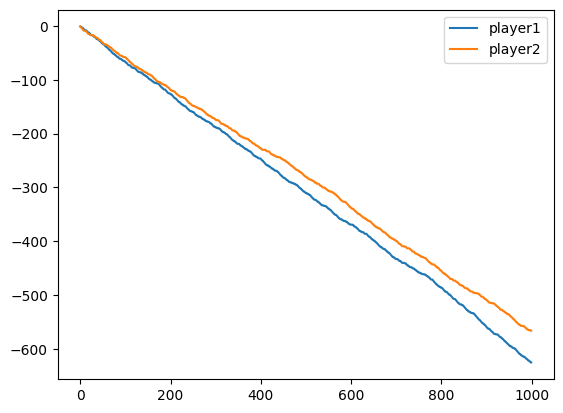

In [8]:
#@title Case - player1 waits, player2 plays
episodes = 1000

episode_rews = []

for _ in range(episodes):

    obs = env.reset()
    while env.agents:
        acts = {
            "player1": 0,
            "player2": 1
        }

        obs, rews, terms, truncs, infos = env.step(acts)
        # print(obs, rews)

    episode_rews.append([rews['player1'], rews['player2']])

arr = np.array(episode_rews)
death_rates = np.sum(arr, axis=0) / np.sum(arr, axis=0)[0]
print(f"death rate of player2: {(np.sum(arr, axis=0) / arr.shape[0])[-1] * -1:.3f}")
print(f"ratio of death rate of player2 with respect to player1: {death_rates[-1]:.3f}")
plt.plot(arr.cumsum(axis=0))
plt.legend(("player1", "player2"))
plt.show()

death rate of player2: 0.421
ratio of death rate of player2 with respect to player1: 0.690


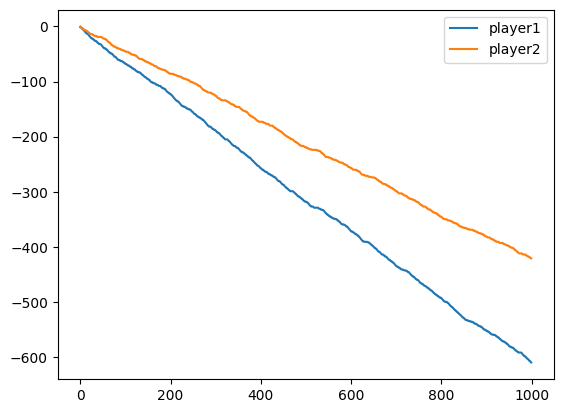

In [9]:
#@title Case - player1 plays, player2 waits
episodes = 1000

episode_rews = []

for _ in range(episodes):

    obs = env.reset()
    while env.agents:
        acts = {
            "player1": 1,
            "player2": 0
        }

        obs, rews, terms, truncs, infos = env.step(acts)
        # print(obs, rews)

    episode_rews.append([rews['player1'], rews['player2']])

arr = np.array(episode_rews)
death_rates = np.sum(arr, axis=0) / np.sum(arr, axis=0)[0]
print(f"death rate of player2: {(np.sum(arr, axis=0) / arr.shape[0])[-1] * -1:.3f}")
print(f"ratio of death rate of player2 with respect to player1: {death_rates[-1]:.3f}")
plt.plot(arr.cumsum(axis=0))
plt.legend(("player1", "player2"))
plt.show()

death rate of player2: 0.397
ratio of death rate of player2 with respect to player1: 0.748


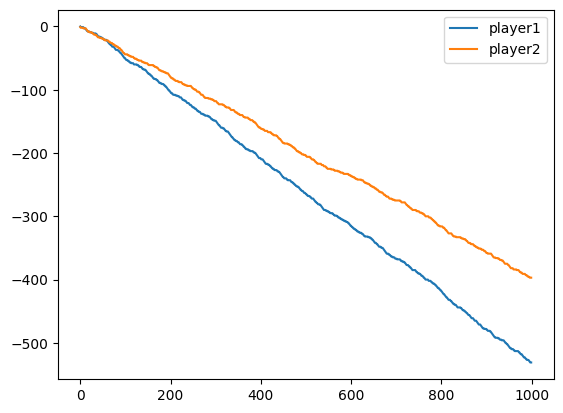

In [10]:
#@title Case - Always play vs random agent
episodes = 1000

episode_rews = []

for _ in range(episodes):

    obs = env.reset()
    while env.agents:
        acts = {
            "player1": 1,
            "player2": np.random.choice([0, 1])
        }

        obs, rews, terms, truncs, infos = env.step(acts)
        # print(obs, rews)

    episode_rews.append([rews['player1'], rews['player2']])

arr = np.array(episode_rews)
death_rates = np.sum(arr, axis=0) / np.sum(arr, axis=0)[0]
print(f"death rate of player2: {(np.sum(arr, axis=0) / arr.shape[0])[-1] * -1:.3f}")
print(f"ratio of death rate of player2 with respect to player1: {death_rates[-1]:.3f}")
plt.plot(arr.cumsum(axis=0))
plt.legend(("player1", "player2"))
plt.show()

death rate of player2: 0.528
ratio of death rate of player2 with respect to player1: 0.873


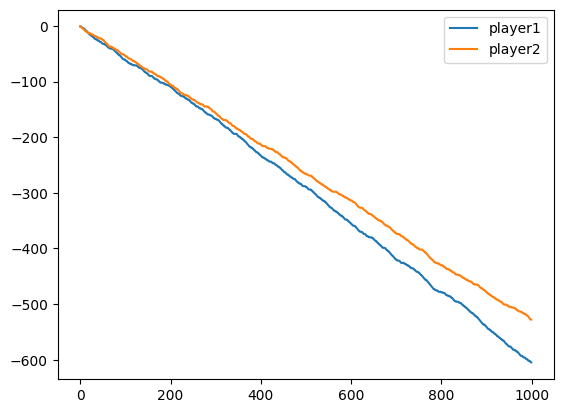

In [11]:
#@title Case - Always wait vs random agent
episodes = 1000

episode_rews = []

for _ in range(episodes):

    obs = env.reset()
    while env.agents:
        acts = {
            "player1": 0,
            "player2": np.random.choice([0, 1])
        }

        obs, rews, terms, truncs, infos = env.step(acts)
        # print(obs, rews)

    episode_rews.append([rews['player1'], rews['player2']])

arr = np.array(episode_rews)
death_rates = np.sum(arr, axis=0) / np.sum(arr, axis=0)[0]
print(f"death rate of player2: {(np.sum(arr, axis=0) / arr.shape[0])[-1] * -1:.3f}")
print(f"ratio of death rate of player2 with respect to player1: {death_rates[-1]:.3f}")
plt.plot(arr.cumsum(axis=0))
plt.legend(("player1", "player2"))
plt.show()

death rate of player2: 0.206
ratio of death rate of player2 with respect to player1: 0.365


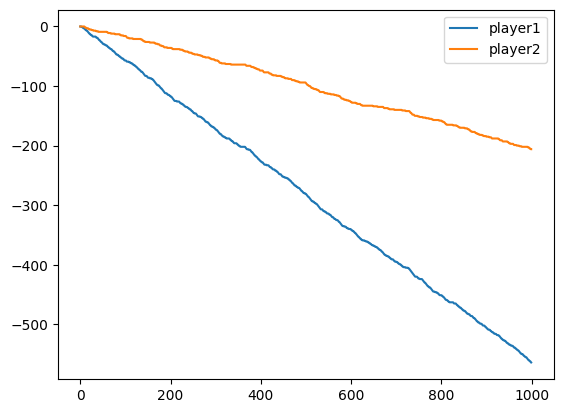

In [12]:
#@title Case - Always play vs hail mary
episodes = 1000

episode_rews = []

for _ in range(episodes):

    obs = env.reset()
    while env.agents:
        acts = {
            "player1": 1,
            "player2": 1 if obs["player2"]["observation"][0, 2] <= 1 else 0
        }

        obs, rews, terms, truncs, infos = env.step(acts)
        # print(obs, rews)

    episode_rews.append([rews['player1'], rews['player2']])

arr = np.array(episode_rews)
death_rates = np.sum(arr, axis=0) / np.sum(arr, axis=0)[0]
print(f"death rate of player2: {(np.sum(arr, axis=0) / arr.shape[0])[-1] * -1:.3f}")
print(f"ratio of death rate of player2 with respect to player1: {death_rates[-1]:.3f}")
plt.plot(arr.cumsum(axis=0))
plt.legend(("player1", "player2"))
plt.show()

death rate of player2: 0.306
ratio of death rate of player2 with respect to player1: 0.498


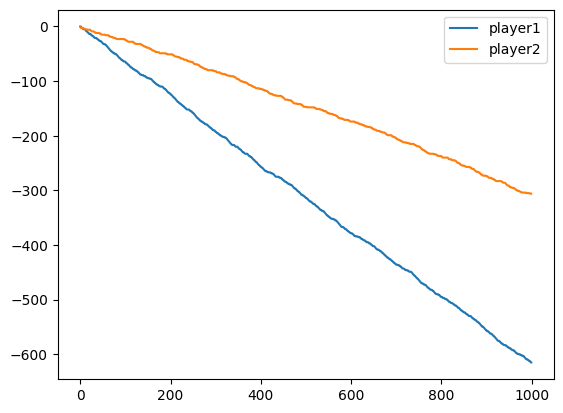

In [13]:
#@title Case - Always wait vs hail mary
episodes = 1000

episode_rews = []

for _ in range(episodes):

    obs = env.reset()
    while env.agents:
        acts = {
            "player1": 0,
            "player2": 1 if obs["player2"]["observation"][0, 2] <= 1 else 0
        }

        obs, rews, terms, truncs, infos = env.step(acts)
        # print(obs, rews)

    episode_rews.append([rews['player1'], rews['player2']])

arr = np.array(episode_rews)
death_rates = np.sum(arr, axis=0) / np.sum(arr, axis=0)[0]
print(f"death rate of player2: {(np.sum(arr, axis=0) / arr.shape[0])[-1] * -1:.3f}")
print(f"ratio of death rate of player2 with respect to player1: {death_rates[-1]:.3f}")
plt.plot(arr.cumsum(axis=0))
plt.legend(("player1", "player2"))
plt.show()

In [14]:
#@title Load optimal policy

def optimal(obs):
    df = pd.read_csv("models/optimal_policy.csv")
    return df.loc[
        (df["days_left"] == obs["player1"]["observation"][0][0]) &
        (df["player1_life_points"] == obs["player1"]["observation"][0][1]) &
        (df["player2_life_points"] == obs["player1"]["observation"][0][2]) &
        (df["player1_prob_payoff"] == obs["player1"]["observation"][0][3])
    ]["action"].values[0] - 1

death rate of player2: 0.241
ratio of death rate of player2 with respect to player1: 0.480


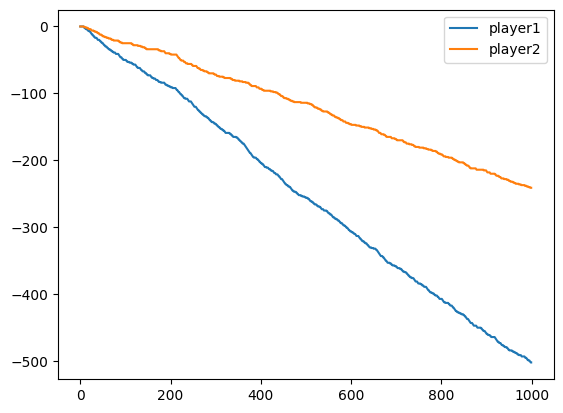

In [15]:
#@title Case - hail mary vs optimal
episodes = 1000

episode_rews = []

for _ in range(episodes):

    obs = env.reset()
    while env.agents:
        acts = {
            "player1": 1 if obs["player2"]["observation"][0, 2] <= 1 else 0,
            "player2": optimal(obs)
        }

        obs, rews, terms, truncs, infos = env.step(acts)
        # print(obs, rews)

    episode_rews.append([rews['player1'], rews['player2']])

arr = np.array(episode_rews)
death_rates = np.sum(arr, axis=0) / np.sum(arr, axis=0)[0]
print(f"death rate of player2: {(np.sum(arr, axis=0) / arr.shape[0])[-1] * -1:.3f}")
print(f"ratio of death rate of player2 with respect to player1: {death_rates[-1]:.3f}")
plt.plot(arr.cumsum(axis=0))
plt.legend(("player1", "player2"))
plt.show()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


death rate of player2: 0.354
ratio of death rate of player2 with respect to player1: 0.561


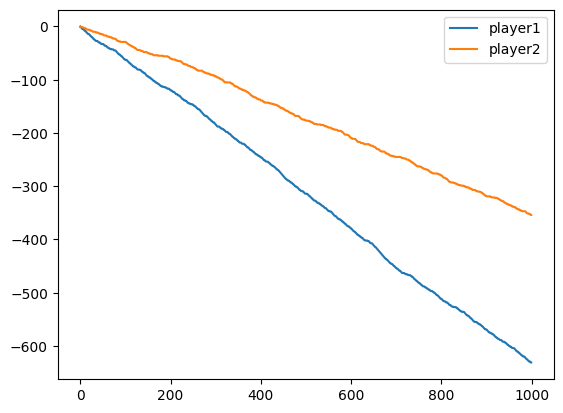

In [16]:
#@title Case - Always wait vs optimal
episodes = 1000

episode_rews = []

for _ in range(episodes):

    obs = env.reset()
    while env.agents:
        acts = {
            "player1": 0,
            "player2": optimal(obs)
        }

        obs, rews, terms, truncs, infos = env.step(acts)
        # print(obs, rews)

    episode_rews.append([rews['player1'], rews['player2']])

arr = np.array(episode_rews)
death_rates = np.sum(arr, axis=0) / np.sum(arr, axis=0)[0]
print(f"death rate of player2: {(np.sum(arr, axis=0) / arr.shape[0])[-1] * -1:.3f}")
print(f"ratio of death rate of player2 with respect to player1: {death_rates[-1]:.3f}")
plt.plot(arr.cumsum(axis=0))
plt.legend(("player1", "player2"))
plt.show()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


death rate of player2: 0.183
ratio of death rate of player2 with respect to player1: 0.381


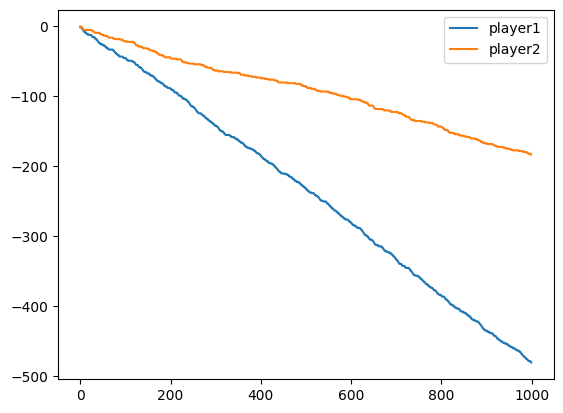

In [17]:
#@title Case - Always play vs optimal
episodes = 1000

episode_rews = []

for _ in range(episodes):

    obs = env.reset()
    while env.agents:
        acts = {
            "player1": 1,
            "player2": optimal(obs)
        }

        obs, rews, terms, truncs, infos = env.step(acts)
        # print(obs, rews)

    episode_rews.append([rews['player1'], rews['player2']])

arr = np.array(episode_rews)
death_rates = np.sum(arr, axis=0) / np.sum(arr, axis=0)[0]
print(f"death rate of player2: {(np.sum(arr, axis=0) / arr.shape[0])[-1] * -1:.3f}")
print(f"ratio of death rate of player2 with respect to player1: {death_rates[-1]:.3f}")
plt.plot(arr.cumsum(axis=0))
plt.legend(("player1", "player2"))
plt.show()

## Deep RL training


In [19]:
#@title Define heuristic algos in Tianshou
## agent that always plays
class AlwaysPlay(BasePolicy):
    def __init__(self, **kwargs):
        self.nolearn = True
        super().__init__(**kwargs)
    
    def forward(self, batch, state = None):
        mask = batch.obs.mask
        logits = np.zeros(mask.shape)
        logits[:, 1] = 1
        logits[~mask] = -np.inf
        return Batch(act=logits.argmax(axis=-1))

    def learn(self, batch):
        return {}

## agent that always waits
class AlwaysWait(BasePolicy):
    def __init__(self, **kwargs):
        self.nolearn = True
        super().__init__(**kwargs)

    def forward(self, batch, state = None):
        mask = batch.obs.mask
        logits = np.zeros(mask.shape)
        logits[:, 0] = 1
        logits[~mask] = -np.inf
        return Batch(act=logits.argmax(axis=-1))

    def learn(self, batch):
        return {}

## agent that waits for low health to play
class HailMary(BasePolicy):
    def __init__(self, **kwargs):
        self.nolearn = True
        super().__init__(**kwargs)

    def forward(self, batch, state = None):
        mask = batch.obs.mask
        logits = np.zeros(mask.shape)
        obs = batch.obs.obs

        for i in range(mask.shape[0]):
            if obs[i, :, 1] <= 1:
                logits[i, 1] = 1
            else:
                logits[i, 0] = 1
        logits[~mask] = -np.inf
        return Batch(act=logits.argmax(axis=-1))

    def learn(self, batch):
        return {}

## optimal agent 
class OptimalPolicy(BasePolicy):
    def __init__(self, **kwargs):
        self.nolearn = True
        super().__init__(**kwargs)

    def forward(self, batch, state = None):
        mask = batch.obs.mask
        logits = np.zeros(mask.shape)
        obs = batch.obs.obs

        df = pd.read_csv("models/optimal_policy.csv")

        for i in range(mask.shape[0]):
            action = df.loc[
                (df["days_left"] == obs[i, :, 0][0]) &
                (df["player1_life_points"] == obs[i, :, 1][0]) &
                (df["player2_life_points"] == obs[i, :, 2][0]) &
                (df["player1_prob_payoff"] == obs[i, :, 3][0])
            ]["action"].values[0] - 1
            if action:
                logits[i, 1] = 1
            else:
                logits[i, 0] = 1
        logits[~mask] = -np.inf
        return Batch(act=logits.argmax(axis=-1))

    def learn(self, batch):
        return {}

## random agent
class RandomAgent(BasePolicy):
    def __init__(self, **kwargs):
        self.nolearn = True
        super().__init__(**kwargs)

    def forward(self, batch, state = None):
        mask = batch.obs.mask
        logits = np.zeros(mask.shape)
        logits[:, np.random.choice([0, 1])] = 1
        logits[~mask] = -np.inf
        return Batch(act=logits.argmax(axis=-1))

    def learn(self, batch):
        return {}

In [20]:
#@title Prerequisites for training
# Step 2: Wrap the environment for Tianshou interfacing
def _get_env():
    env = HomMul()
    vec_env = parallel_to_aec(env)
    return PettingZooEnv(vec_env)

# seed
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)

env = HomMul()
agents =  env.agents[:]

# Step 3: Define policies for each agent
## learning agent
def _get_agent(pretrained=False):
    vec_env = _get_env()
    net = Net(
        state_shape=vec_env.observation_space.shape,
        action_shape=vec_env.action_space.n,
        hidden_sizes=[128, 128],
        device="cuda",
    ).to("cuda")
    optim = Adam(net.parameters(), lr=1e-4)
    model = DQNPolicy(
        model=net,
        optim=optim,
        discount_factor=0.9,
        estimation_step=3,
        target_update_freq=50,
    )

    # if pretrained:
    #     model_save_path = os.path.join("models", "vs_hail_mary.pth")
    #     model.load_state_dict(torch.load(model_save_path))
    return model

agent_learn1 = _get_agent(pretrained=True)
agent_learn2 = _get_agent(pretrained=True)

policy = MultiAgentPolicyManager([agent_learn1, agent_learn2],  _get_env())

train_envs = DummyVectorEnv([_get_env for _ in range(5)])
test_envs = DummyVectorEnv([_get_env for _ in range(2)])
train_envs.seed(seed)
test_envs.seed(seed)

# Step 4: Collector setup
train_collector = Collector(
    policy,
    train_envs,
    VectorReplayBuffer(20_000, len(train_envs)),
    exploration_noise=True,
)
test_collector = Collector(policy, test_envs, exploration_noise=True)

train_collector.collect(n_step=50)

def save_best_fn(policy):
    model_save_path1 = os.path.join("log", "hommul", "dqn", "policy1.pth")
    model_save_path2 = os.path.join("log", "hommul", "dqn", "policy2.pth")
    os.makedirs(os.path.join("log", "hommul", "dqn"), exist_ok=True)
    if not hasattr(policy.policies[agents[0]], 'nolearn'):
        torch.save(policy.policies[agents[0]].state_dict(), model_save_path1)
    if not hasattr(policy.policies[agents[1]], 'nolearn'):
        torch.save(policy.policies[agents[1]].state_dict(), model_save_path2)

def stop_fn(mean_rewards):
    return mean_rewards >= 10

def train_fn(epoch, env_step):
    # freeze training for player1
    if not hasattr(policy.policies[agents[0]], 'nolearn'):
        policy.policies[agents[0]].set_eps(0.05)

    if not hasattr(policy.policies[agents[1]], 'nolearn'):
        policy.policies[agents[1]].set_eps(0.1)

def test_fn(epoch, env_step):
    if not hasattr(policy.policies[agents[0]], 'nolearn'):
        policy.policies[agents[0]].set_eps(0.05)

    if not hasattr(policy.policies[agents[1]], 'nolearn'):
        policy.policies[agents[1]].set_eps(0.05)

def reward_metric(rews):
    return rews[:, 1]

In [21]:
#@title Clear logs and setup TensorBoard
!rm -rf /content/HomMul/log

log_path = os.path.join("log", "hommul", "dqn")
writer = SummaryWriter(log_path)
logger = TensorboardLogger(writer)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [22]:
#@title Training
# Step 5: Run trainer
result = offpolicy_trainer(
    policy=policy,
    train_collector=train_collector,
    test_collector=test_collector,
    max_epoch=100,
    step_per_epoch=1000,
    step_per_collect=50,
    episode_per_test=100,
    batch_size=64,
    train_fn=train_fn,
    test_fn=test_fn,
    stop_fn=stop_fn,
    save_best_fn=save_best_fn,
    update_per_step=0.1,
    test_in_train=False,
    reward_metric=reward_metric,
    logger=logger
)
result

Epoch #1: 1001it [00:02, 365.07it/s, env_step=1000, len=2, n/ep=16, n/st=50, player1/loss=0.227, player2/loss=0.354, rew=-0.31]                          


Epoch #1: test_reward: -0.340000 ± 0.473709, best_reward: -0.340000 ± 0.473709 in #1


Epoch #2: 1001it [00:01, 744.54it/s, env_step=2000, len=3, n/ep=16, n/st=50, player1/loss=0.183, player2/loss=0.217, rew=-0.25]                          


Epoch #2: test_reward: -0.220000 ± 0.414246, best_reward: -0.220000 ± 0.414246 in #2


Epoch #3: 1001it [00:01, 754.65it/s, env_step=3000, len=2, n/ep=17, n/st=50, player1/loss=0.169, player2/loss=0.182, rew=-0.29]                          


Epoch #3: test_reward: -0.220000 ± 0.414246, best_reward: -0.220000 ± 0.414246 in #2


Epoch #4: 1001it [00:01, 729.20it/s, env_step=4000, len=3, n/ep=17, n/st=50, player1/loss=0.165, player2/loss=0.203, rew=-0.29]                          


Epoch #4: test_reward: -0.390000 ± 0.487750, best_reward: -0.220000 ± 0.414246 in #2


Epoch #5: 1001it [00:01, 576.29it/s, env_step=5000, len=2, n/ep=18, n/st=50, player1/loss=0.191, player2/loss=0.252, rew=-0.06]                          


Epoch #5: test_reward: -0.300000 ± 0.458258, best_reward: -0.220000 ± 0.414246 in #2


Epoch #6: 1001it [00:01, 694.82it/s, env_step=6000, len=2, n/ep=19, n/st=50, player1/loss=0.192, player2/loss=0.284, rew=-0.37]                          


Epoch #6: test_reward: -0.290000 ± 0.453762, best_reward: -0.220000 ± 0.414246 in #2


Epoch #7: 1001it [00:01, 777.25it/s, env_step=7000, len=2, n/ep=19, n/st=50, player1/loss=0.234, player2/loss=0.328, rew=-0.26]                          


Epoch #7: test_reward: -0.280000 ± 0.448999, best_reward: -0.220000 ± 0.414246 in #2


Epoch #8: 1001it [00:01, 760.12it/s, env_step=8000, len=3, n/ep=13, n/st=50, player1/loss=0.267, player2/loss=0.362, rew=-0.08]                          


Epoch #8: test_reward: -0.210000 ± 0.407308, best_reward: -0.210000 ± 0.407308 in #8


Epoch #9: 1001it [00:01, 755.98it/s, env_step=9000, len=3, n/ep=15, n/st=50, player1/loss=0.305, player2/loss=0.387, rew=-0.13]                          


Epoch #9: test_reward: -0.260000 ± 0.438634, best_reward: -0.210000 ± 0.407308 in #8


Epoch #10: 1001it [00:01, 753.11it/s, env_step=10000, len=2, n/ep=19, n/st=50, player1/loss=0.310, player2/loss=0.415, rew=-0.26]                          


Epoch #10: test_reward: -0.270000 ± 0.443959, best_reward: -0.210000 ± 0.407308 in #8


Epoch #11: 1001it [00:01, 736.64it/s, env_step=11000, len=2, n/ep=19, n/st=50, player1/loss=0.302, player2/loss=0.449, rew=-0.21]                          


Epoch #11: test_reward: -0.250000 ± 0.433013, best_reward: -0.210000 ± 0.407308 in #8


Epoch #12: 1001it [00:01, 625.57it/s, env_step=12000, len=2, n/ep=18, n/st=50, player1/loss=0.293, player2/loss=0.476, rew=-0.44]                          


Epoch #12: test_reward: -0.320000 ± 0.466476, best_reward: -0.210000 ± 0.407308 in #8


Epoch #13: 1001it [00:01, 547.04it/s, env_step=13000, len=3, n/ep=16, n/st=50, player1/loss=0.264, player2/loss=0.496, rew=-0.31]                          


Epoch #13: test_reward: -0.280000 ± 0.448999, best_reward: -0.210000 ± 0.407308 in #8


Epoch #14: 1001it [00:01, 746.28it/s, env_step=14000, len=3, n/ep=17, n/st=50, player1/loss=0.261, player2/loss=0.554, rew=-0.24]                          


Epoch #14: test_reward: -0.340000 ± 0.473709, best_reward: -0.210000 ± 0.407308 in #8


Epoch #15: 1001it [00:01, 756.56it/s, env_step=15000, len=2, n/ep=17, n/st=50, player1/loss=0.263, player2/loss=0.653, rew=-0.24]                          


Epoch #15: test_reward: -0.220000 ± 0.414246, best_reward: -0.210000 ± 0.407308 in #8


Epoch #16: 1001it [00:01, 765.67it/s, env_step=16000, len=2, n/ep=18, n/st=50, player1/loss=0.273, player2/loss=0.698, rew=-0.28]                          


Epoch #16: test_reward: -0.270000 ± 0.443959, best_reward: -0.210000 ± 0.407308 in #8


Epoch #17: 1001it [00:01, 755.40it/s, env_step=17000, len=3, n/ep=16, n/st=50, player1/loss=0.244, player2/loss=0.764, rew=-0.19]                          


Epoch #17: test_reward: -0.250000 ± 0.433013, best_reward: -0.210000 ± 0.407308 in #8


Epoch #18: 1001it [00:01, 753.67it/s, env_step=18000, len=3, n/ep=17, n/st=50, player1/loss=0.275, player2/loss=0.784, rew=-0.35]                          


Epoch #18: test_reward: -0.330000 ± 0.470213, best_reward: -0.210000 ± 0.407308 in #8


Epoch #19: 1001it [00:01, 774.04it/s, env_step=19000, len=2, n/ep=17, n/st=50, player1/loss=0.269, player2/loss=0.834, rew=-0.24]                          


Epoch #19: test_reward: -0.250000 ± 0.433013, best_reward: -0.210000 ± 0.407308 in #8


Epoch #20: 1001it [00:01, 598.14it/s, env_step=20000, len=2, n/ep=17, n/st=50, player1/loss=0.258, player2/loss=0.849, rew=-0.24]                          


Epoch #20: test_reward: -0.200000 ± 0.400000, best_reward: -0.200000 ± 0.400000 in #20


Epoch #21: 1001it [00:01, 610.05it/s, env_step=21000, len=2, n/ep=20, n/st=50, player1/loss=0.247, player2/loss=0.824, rew=-0.35]                          


Epoch #21: test_reward: -0.280000 ± 0.448999, best_reward: -0.200000 ± 0.400000 in #20


Epoch #22: 1001it [00:01, 773.86it/s, env_step=22000, len=2, n/ep=18, n/st=50, player1/loss=0.234, player2/loss=0.898, rew=-0.28]                          


Epoch #22: test_reward: -0.340000 ± 0.473709, best_reward: -0.200000 ± 0.400000 in #20


Epoch #23: 1001it [00:01, 770.03it/s, env_step=23000, len=2, n/ep=18, n/st=50, player1/loss=0.250, player2/loss=0.943, rew=-0.11]                          


Epoch #23: test_reward: -0.240000 ± 0.427083, best_reward: -0.200000 ± 0.400000 in #20


Epoch #24: 1001it [00:01, 784.19it/s, env_step=24000, len=3, n/ep=16, n/st=50, player1/loss=0.236, player2/loss=0.985, rew=-0.25]                          


Epoch #24: test_reward: -0.220000 ± 0.414246, best_reward: -0.200000 ± 0.400000 in #20


Epoch #25: 1001it [00:01, 790.66it/s, env_step=25000, len=3, n/ep=15, n/st=50, player1/loss=0.216, player2/loss=0.996, rew=-0.20]                          


Epoch #25: test_reward: -0.190000 ± 0.392301, best_reward: -0.190000 ± 0.392301 in #25


Epoch #26: 1001it [00:01, 769.78it/s, env_step=26000, len=2, n/ep=15, n/st=50, player1/loss=0.223, player2/loss=1.020, rew=-0.27]                          


Epoch #26: test_reward: -0.190000 ± 0.392301, best_reward: -0.190000 ± 0.392301 in #25


Epoch #27: 1001it [00:01, 780.08it/s, env_step=27000, len=2, n/ep=17, n/st=50, player1/loss=0.227, player2/loss=0.927, rew=-0.06]                          


Epoch #27: test_reward: -0.210000 ± 0.407308, best_reward: -0.190000 ± 0.392301 in #25


Epoch #28: 1001it [00:01, 611.08it/s, env_step=28000, len=2, n/ep=17, n/st=50, player1/loss=0.211, player2/loss=1.023, rew=-0.18]                          


Epoch #28: test_reward: -0.300000 ± 0.458258, best_reward: -0.190000 ± 0.392301 in #25


Epoch #29: 1001it [00:01, 636.31it/s, env_step=29000, len=2, n/ep=18, n/st=50, player1/loss=0.226, player2/loss=1.037, rew=-0.17]                          


Epoch #29: test_reward: -0.270000 ± 0.443959, best_reward: -0.190000 ± 0.392301 in #25


Epoch #30: 1001it [00:01, 776.77it/s, env_step=30000, len=2, n/ep=20, n/st=50, player1/loss=0.223, player2/loss=1.016, rew=-0.35]                          


Epoch #30: test_reward: -0.250000 ± 0.433013, best_reward: -0.190000 ± 0.392301 in #25


Epoch #31: 1001it [00:01, 776.18it/s, env_step=31000, len=2, n/ep=17, n/st=50, player1/loss=0.228, player2/loss=1.008, rew=-0.24]                          


Epoch #31: test_reward: -0.240000 ± 0.427083, best_reward: -0.190000 ± 0.392301 in #25


Epoch #32: 1001it [00:01, 772.90it/s, env_step=32000, len=2, n/ep=18, n/st=50, player1/loss=0.230, player2/loss=1.004, rew=-0.44]                          


Epoch #32: test_reward: -0.310000 ± 0.462493, best_reward: -0.190000 ± 0.392301 in #25


Epoch #33: 1001it [00:01, 783.21it/s, env_step=33000, len=2, n/ep=16, n/st=50, player1/loss=0.244, player2/loss=0.965, rew=-0.38]                          


Epoch #33: test_reward: -0.310000 ± 0.462493, best_reward: -0.190000 ± 0.392301 in #25


Epoch #34: 1001it [00:01, 795.79it/s, env_step=34000, len=3, n/ep=16, n/st=50, player1/loss=0.234, player2/loss=0.890, rew=-0.12]                          


Epoch #34: test_reward: -0.250000 ± 0.433013, best_reward: -0.190000 ± 0.392301 in #25


Epoch #35: 1001it [00:01, 775.97it/s, env_step=35000, len=2, n/ep=18, n/st=50, player1/loss=0.245, player2/loss=0.896, rew=-0.28]                          


Epoch #35: test_reward: -0.220000 ± 0.414246, best_reward: -0.190000 ± 0.392301 in #25


Epoch #36: 1001it [00:01, 598.69it/s, env_step=36000, len=3, n/ep=17, n/st=50, player1/loss=0.247, player2/loss=1.029, rew=-0.06]                          


Epoch #36: test_reward: -0.220000 ± 0.414246, best_reward: -0.190000 ± 0.392301 in #25


Epoch #37: 1001it [00:01, 661.11it/s, env_step=37000, len=2, n/ep=20, n/st=50, player1/loss=0.239, player2/loss=1.003, rew=-0.20]                          


Epoch #37: test_reward: -0.260000 ± 0.438634, best_reward: -0.190000 ± 0.392301 in #25


Epoch #38: 1001it [00:01, 745.56it/s, env_step=38000, len=2, n/ep=18, n/st=50, player1/loss=0.231, player2/loss=0.973, rew=-0.28]                          


Epoch #38: test_reward: -0.170000 ± 0.375633, best_reward: -0.170000 ± 0.375633 in #38


Epoch #39: 1001it [00:01, 595.45it/s, env_step=39000, len=3, n/ep=16, n/st=50, player1/loss=0.240, player2/loss=0.943, rew=-0.31]                          


Epoch #39: test_reward: -0.270000 ± 0.443959, best_reward: -0.170000 ± 0.375633 in #38


Epoch #40: 1001it [00:02, 399.62it/s, env_step=40000, len=2, n/ep=18, n/st=50, player1/loss=0.256, player2/loss=1.006, rew=-0.28]                          


Epoch #40: test_reward: -0.220000 ± 0.414246, best_reward: -0.170000 ± 0.375633 in #38


Epoch #41: 1001it [00:01, 606.95it/s, env_step=41000, len=2, n/ep=18, n/st=50, player1/loss=0.271, player2/loss=1.055, rew=-0.33]                          


Epoch #41: test_reward: -0.280000 ± 0.448999, best_reward: -0.170000 ± 0.375633 in #38


Epoch #42: 1001it [00:01, 699.62it/s, env_step=42000, len=2, n/ep=20, n/st=50, player1/loss=0.255, player2/loss=0.970, rew=-0.20]                          


Epoch #42: test_reward: -0.250000 ± 0.433013, best_reward: -0.170000 ± 0.375633 in #38


Epoch #43: 1001it [00:01, 571.39it/s, env_step=43000, len=3, n/ep=17, n/st=50, player1/loss=0.266, player2/loss=1.003, rew=-0.29]                          


Epoch #43: test_reward: -0.190000 ± 0.392301, best_reward: -0.170000 ± 0.375633 in #38


Epoch #44: 1001it [00:01, 794.34it/s, env_step=44000, len=2, n/ep=18, n/st=50, player1/loss=0.261, player2/loss=1.020, rew=-0.39]                          


Epoch #44: test_reward: -0.210000 ± 0.407308, best_reward: -0.170000 ± 0.375633 in #38


Epoch #45: 1001it [00:01, 784.08it/s, env_step=45000, len=3, n/ep=17, n/st=50, player1/loss=0.277, player2/loss=1.065, rew=-0.18]                          


Epoch #45: test_reward: -0.120000 ± 0.324962, best_reward: -0.120000 ± 0.324962 in #45


Epoch #46: 1001it [00:01, 787.49it/s, env_step=46000, len=2, n/ep=16, n/st=50, player1/loss=0.265, player2/loss=1.093, rew=-0.44]                          


Epoch #46: test_reward: -0.250000 ± 0.433013, best_reward: -0.120000 ± 0.324962 in #45


Epoch #47: 1001it [00:01, 766.36it/s, env_step=47000, len=2, n/ep=19, n/st=50, player1/loss=0.295, player2/loss=1.131, rew=-0.26]                          


Epoch #47: test_reward: -0.320000 ± 0.466476, best_reward: -0.120000 ± 0.324962 in #45


Epoch #48: 1001it [00:01, 786.68it/s, env_step=48000, len=2, n/ep=18, n/st=50, player1/loss=0.319, player2/loss=1.062, rew=-0.28]                          


Epoch #48: test_reward: -0.250000 ± 0.433013, best_reward: -0.120000 ± 0.324962 in #45


Epoch #49: 1001it [00:01, 765.30it/s, env_step=49000, len=2, n/ep=20, n/st=50, player1/loss=0.299, player2/loss=1.059, rew=-0.25]                          


Epoch #49: test_reward: -0.260000 ± 0.438634, best_reward: -0.120000 ± 0.324962 in #45


Epoch #50: 1001it [00:01, 678.27it/s, env_step=50000, len=2, n/ep=20, n/st=50, player1/loss=0.278, player2/loss=1.115, rew=-0.40]                          


Epoch #50: test_reward: -0.240000 ± 0.427083, best_reward: -0.120000 ± 0.324962 in #45


Epoch #51: 1001it [00:01, 584.74it/s, env_step=51000, len=2, n/ep=21, n/st=50, player1/loss=0.316, player2/loss=1.028, rew=-0.24]                          


Epoch #51: test_reward: -0.240000 ± 0.427083, best_reward: -0.120000 ± 0.324962 in #45


Epoch #52: 1001it [00:01, 792.91it/s, env_step=52000, len=2, n/ep=17, n/st=50, player1/loss=0.319, player2/loss=1.130, rew=-0.24]                          


Epoch #52: test_reward: -0.170000 ± 0.375633, best_reward: -0.120000 ± 0.324962 in #45


Epoch #53: 1001it [00:01, 772.22it/s, env_step=53000, len=2, n/ep=18, n/st=50, player1/loss=0.292, player2/loss=1.120, rew=-0.22]                          


Epoch #53: test_reward: -0.220000 ± 0.414246, best_reward: -0.120000 ± 0.324962 in #45


Epoch #54: 1001it [00:01, 793.35it/s, env_step=54000, len=3, n/ep=17, n/st=50, player1/loss=0.311, player2/loss=1.142, rew=-0.12]                          


Epoch #54: test_reward: -0.210000 ± 0.407308, best_reward: -0.120000 ± 0.324962 in #45


Epoch #55: 1001it [00:01, 767.44it/s, env_step=55000, len=2, n/ep=18, n/st=50, player1/loss=0.286, player2/loss=1.111, rew=-0.50]                          


Epoch #55: test_reward: -0.220000 ± 0.414246, best_reward: -0.120000 ± 0.324962 in #45


Epoch #56: 1001it [00:01, 749.85it/s, env_step=56000, len=3, n/ep=18, n/st=50, player1/loss=0.315, player2/loss=1.090, rew=-0.11]                          


Epoch #56: test_reward: -0.180000 ± 0.384187, best_reward: -0.120000 ± 0.324962 in #45


Epoch #57: 1001it [00:01, 764.85it/s, env_step=57000, len=2, n/ep=15, n/st=50, player1/loss=0.313, player2/loss=1.053, rew=-0.27]                          


Epoch #57: test_reward: -0.290000 ± 0.453762, best_reward: -0.120000 ± 0.324962 in #45


Epoch #58: 1001it [00:01, 652.94it/s, env_step=58000, len=3, n/ep=17, n/st=50, player1/loss=0.299, player2/loss=1.157, rew=-0.24]                          


Epoch #58: test_reward: -0.280000 ± 0.448999, best_reward: -0.120000 ± 0.324962 in #45


Epoch #59: 1001it [00:01, 590.11it/s, env_step=59000, len=3, n/ep=15, n/st=50, player1/loss=0.306, player2/loss=1.191, rew=-0.20]                          


Epoch #59: test_reward: -0.270000 ± 0.443959, best_reward: -0.120000 ± 0.324962 in #45


Epoch #60: 1001it [00:01, 795.80it/s, env_step=60000, len=2, n/ep=17, n/st=50, player1/loss=0.313, player2/loss=1.078, rew=-0.24]                          


Epoch #60: test_reward: -0.310000 ± 0.462493, best_reward: -0.120000 ± 0.324962 in #45


Epoch #61: 1001it [00:01, 788.96it/s, env_step=61000, len=2, n/ep=18, n/st=50, player1/loss=0.305, player2/loss=1.119, rew=-0.22]                          


Epoch #61: test_reward: -0.300000 ± 0.458258, best_reward: -0.120000 ± 0.324962 in #45


Epoch #62: 1001it [00:01, 790.33it/s, env_step=62000, len=2, n/ep=18, n/st=50, player1/loss=0.325, player2/loss=1.102, rew=-0.39]                          


Epoch #62: test_reward: -0.220000 ± 0.414246, best_reward: -0.120000 ± 0.324962 in #45


Epoch #63: 1001it [00:01, 784.25it/s, env_step=63000, len=2, n/ep=19, n/st=50, player1/loss=0.322, player2/loss=1.041, rew=-0.26]                          


Epoch #63: test_reward: -0.240000 ± 0.427083, best_reward: -0.120000 ± 0.324962 in #45


Epoch #64: 1001it [00:01, 790.72it/s, env_step=64000, len=2, n/ep=18, n/st=50, player1/loss=0.338, player2/loss=1.204, rew=-0.28]                          


Epoch #64: test_reward: -0.280000 ± 0.448999, best_reward: -0.120000 ± 0.324962 in #45


Epoch #65: 1001it [00:01, 780.82it/s, env_step=65000, len=2, n/ep=19, n/st=50, player1/loss=0.306, player2/loss=1.119, rew=-0.16]                          


Epoch #65: test_reward: -0.260000 ± 0.438634, best_reward: -0.120000 ± 0.324962 in #45


Epoch #66: 1001it [00:01, 658.56it/s, env_step=66000, len=3, n/ep=17, n/st=50, player1/loss=0.321, player2/loss=1.256, rew=-0.41]                          


Epoch #66: test_reward: -0.220000 ± 0.414246, best_reward: -0.120000 ± 0.324962 in #45


Epoch #67: 1001it [00:01, 601.56it/s, env_step=67000, len=2, n/ep=19, n/st=50, player1/loss=0.326, player2/loss=1.079, rew=-0.26]                          


Epoch #67: test_reward: -0.230000 ± 0.420833, best_reward: -0.120000 ± 0.324962 in #45


Epoch #68: 1001it [00:01, 780.97it/s, env_step=68000, len=2, n/ep=18, n/st=50, player1/loss=0.340, player2/loss=1.166, rew=-0.33]                          


Epoch #68: test_reward: -0.170000 ± 0.375633, best_reward: -0.120000 ± 0.324962 in #45


Epoch #69: 1001it [00:01, 783.85it/s, env_step=69000, len=2, n/ep=16, n/st=50, player1/loss=0.335, player2/loss=1.156, rew=-0.06]                          


Epoch #69: test_reward: -0.300000 ± 0.458258, best_reward: -0.120000 ± 0.324962 in #45


Epoch #70: 1001it [00:01, 781.76it/s, env_step=70000, len=2, n/ep=17, n/st=50, player1/loss=0.311, player2/loss=1.138, rew=-0.24]                          


Epoch #70: test_reward: -0.210000 ± 0.407308, best_reward: -0.120000 ± 0.324962 in #45


Epoch #71: 1001it [00:01, 789.25it/s, env_step=71000, len=2, n/ep=19, n/st=50, player1/loss=0.350, player2/loss=1.140, rew=-0.16]                          


Epoch #71: test_reward: -0.250000 ± 0.433013, best_reward: -0.120000 ± 0.324962 in #45


Epoch #72: 1001it [00:01, 788.09it/s, env_step=72000, len=3, n/ep=17, n/st=50, player1/loss=0.314, player2/loss=1.112, rew=-0.24]                          


Epoch #72: test_reward: -0.210000 ± 0.407308, best_reward: -0.120000 ± 0.324962 in #45


Epoch #73: 1001it [00:01, 798.30it/s, env_step=73000, len=2, n/ep=17, n/st=50, player1/loss=0.328, player2/loss=1.192, rew=-0.18]                          


Epoch #73: test_reward: -0.260000 ± 0.438634, best_reward: -0.120000 ± 0.324962 in #45


Epoch #74: 1001it [00:01, 645.55it/s, env_step=74000, len=2, n/ep=17, n/st=50, player1/loss=0.354, player2/loss=1.174, rew=-0.47]                          


Epoch #74: test_reward: -0.350000 ± 0.476970, best_reward: -0.120000 ± 0.324962 in #45


Epoch #75: 1001it [00:01, 583.08it/s, env_step=75000, len=3, n/ep=14, n/st=50, player1/loss=0.333, player2/loss=1.219, rew=-0.14]                          


Epoch #75: test_reward: -0.250000 ± 0.433013, best_reward: -0.120000 ± 0.324962 in #45


Epoch #76: 1001it [00:01, 776.21it/s, env_step=76000, len=2, n/ep=20, n/st=50, player1/loss=0.332, player2/loss=1.155, rew=-0.15]                          


Epoch #76: test_reward: -0.270000 ± 0.443959, best_reward: -0.120000 ± 0.324962 in #45


Epoch #77: 1001it [00:01, 787.44it/s, env_step=77000, len=2, n/ep=17, n/st=50, player1/loss=0.328, player2/loss=1.228, rew=-0.06]                          


Epoch #77: test_reward: -0.290000 ± 0.453762, best_reward: -0.120000 ± 0.324962 in #45


Epoch #78: 1001it [00:01, 771.90it/s, env_step=78000, len=2, n/ep=17, n/st=50, player1/loss=0.358, player2/loss=1.266, rew=-0.12]                          


Epoch #78: test_reward: -0.280000 ± 0.448999, best_reward: -0.120000 ± 0.324962 in #45


Epoch #79: 1001it [00:01, 779.55it/s, env_step=79000, len=3, n/ep=16, n/st=50, player1/loss=0.342, player2/loss=1.262, rew=-0.31]                          


Epoch #79: test_reward: -0.200000 ± 0.400000, best_reward: -0.120000 ± 0.324962 in #45


Epoch #80: 1001it [00:01, 787.32it/s, env_step=80000, len=3, n/ep=16, n/st=50, player1/loss=0.374, player2/loss=1.183, rew=-0.25]                          


Epoch #80: test_reward: -0.210000 ± 0.407308, best_reward: -0.120000 ± 0.324962 in #45


Epoch #81: 1001it [00:01, 590.84it/s, env_step=81000, len=3, n/ep=16, n/st=50, player1/loss=0.379, player2/loss=1.246, rew=-0.25]                          


Epoch #81: test_reward: -0.230000 ± 0.420833, best_reward: -0.120000 ± 0.324962 in #45


Epoch #82: 1001it [00:03, 269.36it/s, env_step=82000, len=3, n/ep=16, n/st=50, player1/loss=0.396, player2/loss=1.384, rew=-0.31]                          


Epoch #82: test_reward: -0.170000 ± 0.375633, best_reward: -0.120000 ± 0.324962 in #45


Epoch #83: 1001it [00:01, 775.80it/s, env_step=83000, len=2, n/ep=18, n/st=50, player1/loss=0.404, player2/loss=1.275, rew=-0.11]                          


Epoch #83: test_reward: -0.260000 ± 0.438634, best_reward: -0.120000 ± 0.324962 in #45


Epoch #84: 1001it [00:01, 646.96it/s, env_step=84000, len=2, n/ep=17, n/st=50, player1/loss=0.381, player2/loss=1.298, rew=-0.35]                          


Epoch #84: test_reward: -0.290000 ± 0.453762, best_reward: -0.120000 ± 0.324962 in #45


Epoch #85: 1001it [00:01, 772.08it/s, env_step=85000, len=2, n/ep=19, n/st=50, player1/loss=0.400, player2/loss=1.292, rew=-0.37]                          


Epoch #85: test_reward: -0.270000 ± 0.443959, best_reward: -0.120000 ± 0.324962 in #45


Epoch #86: 1001it [00:01, 770.90it/s, env_step=86000, len=2, n/ep=19, n/st=50, player1/loss=0.389, player2/loss=1.291, rew=-0.21]                          


Epoch #86: test_reward: -0.200000 ± 0.400000, best_reward: -0.120000 ± 0.324962 in #45


Epoch #87: 1001it [00:01, 768.08it/s, env_step=87000, len=3, n/ep=17, n/st=50, player1/loss=0.401, player2/loss=1.319, rew=-0.24]                          


Epoch #87: test_reward: -0.270000 ± 0.443959, best_reward: -0.120000 ± 0.324962 in #45


Epoch #88: 1001it [00:01, 675.85it/s, env_step=88000, len=2, n/ep=19, n/st=50, player1/loss=0.421, player2/loss=1.355, rew=-0.21]                          


Epoch #88: test_reward: -0.220000 ± 0.414246, best_reward: -0.120000 ± 0.324962 in #45


Epoch #89: 1001it [00:01, 558.47it/s, env_step=89000, len=3, n/ep=16, n/st=50, player1/loss=0.445, player2/loss=1.490, rew=-0.25]                          


Epoch #89: test_reward: -0.180000 ± 0.384187, best_reward: -0.120000 ± 0.324962 in #45


Epoch #90: 1001it [00:01, 766.95it/s, env_step=90000, len=2, n/ep=19, n/st=50, player1/loss=0.437, player2/loss=1.454, rew=-0.26]                          


Epoch #90: test_reward: -0.290000 ± 0.453762, best_reward: -0.120000 ± 0.324962 in #45


Epoch #91: 1001it [00:01, 755.42it/s, env_step=91000, len=3, n/ep=15, n/st=50, player1/loss=0.454, player2/loss=1.484, rew=-0.07]                          


Epoch #91: test_reward: -0.210000 ± 0.407308, best_reward: -0.120000 ± 0.324962 in #45


Epoch #92: 1001it [00:01, 738.38it/s, env_step=92000, len=2, n/ep=18, n/st=50, player1/loss=0.418, player2/loss=1.521, rew=-0.39]                          


Epoch #92: test_reward: -0.270000 ± 0.443959, best_reward: -0.120000 ± 0.324962 in #45


Epoch #93: 1001it [00:01, 753.72it/s, env_step=93000, len=2, n/ep=19, n/st=50, player1/loss=0.470, player2/loss=1.591, rew=-0.26]                          


Epoch #93: test_reward: -0.190000 ± 0.392301, best_reward: -0.120000 ± 0.324962 in #45


Epoch #94: 1001it [00:01, 711.66it/s, env_step=94000, len=2, n/ep=17, n/st=50, player1/loss=0.433, player2/loss=1.538, rew=-0.29]                          


Epoch #94: test_reward: -0.260000 ± 0.438634, best_reward: -0.120000 ± 0.324962 in #45


Epoch #95: 1001it [00:01, 722.07it/s, env_step=95000, len=3, n/ep=18, n/st=50, player1/loss=0.468, player2/loss=1.563, rew=-0.28]                          


Epoch #95: test_reward: -0.250000 ± 0.433013, best_reward: -0.120000 ± 0.324962 in #45


Epoch #96: 1001it [00:01, 600.69it/s, env_step=96000, len=3, n/ep=16, n/st=50, player1/loss=0.492, player2/loss=1.587, rew=-0.31]                          


Epoch #96: test_reward: -0.190000 ± 0.392301, best_reward: -0.120000 ± 0.324962 in #45


Epoch #97: 1001it [00:01, 622.44it/s, env_step=97000, len=2, n/ep=20, n/st=50, player1/loss=0.474, player2/loss=1.610, rew=-0.20]                          


Epoch #97: test_reward: -0.160000 ± 0.366606, best_reward: -0.120000 ± 0.324962 in #45


Epoch #98: 1001it [00:01, 774.91it/s, env_step=98000, len=2, n/ep=18, n/st=50, player1/loss=0.499, player2/loss=1.690, rew=-0.11]                          


Epoch #98: test_reward: -0.220000 ± 0.414246, best_reward: -0.120000 ± 0.324962 in #45


Epoch #99: 1001it [00:01, 763.09it/s, env_step=99000, len=2, n/ep=17, n/st=50, player1/loss=0.458, player2/loss=1.690, rew=-0.35]                          


Epoch #99: test_reward: -0.210000 ± 0.407308, best_reward: -0.120000 ± 0.324962 in #45


Epoch #100: 1001it [00:01, 774.47it/s, env_step=100000, len=2, n/ep=19, n/st=50, player1/loss=0.468, player2/loss=1.664, rew=-0.32]                          


Epoch #100: test_reward: -0.150000 ± 0.357071, best_reward: -0.120000 ± 0.324962 in #45


{'duration': '170.56s',
 'train_time/model': '96.11s',
 'test_step': 29062,
 'test_episode': 10100,
 'test_time': '25.23s',
 'test_speed': '1151.79 step/s',
 'best_reward': -0.12,
 'best_result': '-0.12 ± 0.32',
 'train_step': 100000,
 'train_episode': 34718,
 'train_time/collector': '49.22s',
 'train_speed': '688.11 step/s'}

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


death rate of player2: 0.242
ratio of death rate of player2 with respect to player1: 0.755


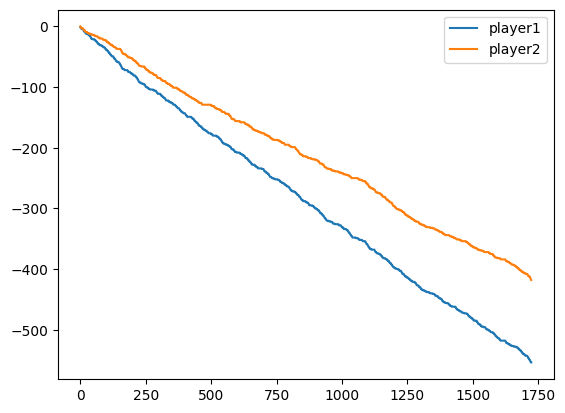

In [23]:
#@title Eval DRL

result = test_collector.collect(n_step=5000)
arr = result["rews"]
death_rates = np.sum(arr, axis=0) / np.sum(arr, axis=0)[0]
print(f"death rate of player2: {(np.sum(arr, axis=0) / arr.shape[0])[-1] * -1:.3f}")
print(f"ratio of death rate of player2 with respect to player1: {death_rates[-1]:.3f}")
plt.plot(arr.cumsum(axis=0))
plt.legend(("player1", "player2"))
plt.show()

In [24]:
#@title Load best model checkpoints

model_save_path1 = os.path.join("log", "hommul", "dqn", "policy1.pth")
model_save_path2 = os.path.join("log", "hommul", "dqn", "policy2.pth")
if not hasattr(policy.policies[agents[0]], 'nolearn'):
    policy.policies[agents[0]].load_state_dict(torch.load(model_save_path1))
if not hasattr(policy.policies[agents[1]], 'nolearn'):
    policy.policies[agents[1]].load_state_dict(torch.load(model_save_path2))

death rate of player2: 0.225
ratio of death rate of player2 with respect to player1: 0.589


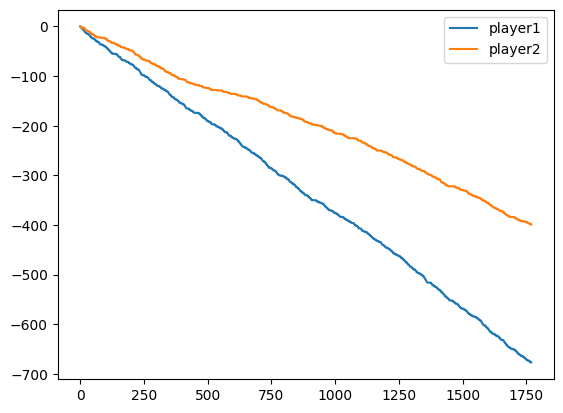

In [25]:
#@title Eval DRL
result = test_collector.collect(n_step=5000)
arr = result["rews"]
death_rates = np.sum(arr, axis=0) / np.sum(arr, axis=0)[0]
print(f"death rate of player2: {(np.sum(arr, axis=0) / arr.shape[0])[-1] * -1:.3f}")
print(f"ratio of death rate of player2 with respect to player1: {death_rates[-1]:.3f}")
plt.plot(arr.cumsum(axis=0))
plt.legend(("player1", "player2"))
plt.show()

In [26]:
#@title Save Policy as CSV

df = []
obs = []

for days_left in range(1, 3):
    for player1_life_points in range(4):
        for player2_life_points in range(4):
            for payoff in [0.2, 0.4]:
                for player1_action in range(0, 3):
                    for player2_action in range(0, 3):
                        curr_obs = [
                            days_left, 
                            player1_life_points, 
                            player2_life_points, 
                            payoff,
                            payoff,
                            player1_action, 
                            player2_action
                        ]
                        obs.append({
                            'agent_id': 'player2',
                            'obs': np.array([curr_obs], dtype='float32'),
                            'mask': [True, True, False]
                        })
                        df.append(curr_obs)

cols = [
    "days_left", 
    "player1_life_points", 
    "player2_life_points", 
    "player1_prob_payoff",
    "player2_prob_payoff",
    "player1_previous_action", 
    "player2_previous_action"
]
df = pd.DataFrame(df, columns=cols)

df["player2_predicted_action"] = policy.policies[agents[1]](Batch(obs=obs, info={})).act
df["player2_logit_wait"] = policy.policies[agents[1]](Batch(obs=obs, info={})).logits.detach().cpu().numpy()[:, 0]
df["player2_logit_play"] = policy.policies[agents[1]](Batch(obs=obs, info={})).logits.detach().cpu().numpy()[:, 1]

df["player1_previous_action"] = df["player1_previous_action"].map({0: "wait", 1: "play", 2: "none"})
df["player2_previous_action"] = df["player2_previous_action"].map({0: "wait", 1: "play", 2: "none"})
df["player2_predicted_action"] = df["player2_predicted_action"].map({0: "wait", 1: "play"})

df.to_csv("outcome_table.csv", index=False)

df.head()

,days_left,player1_life_points,player2_life_points,player1_prob_payoff,player2_prob_payoff,player1_previous_action,player2_previous_action,player2_predicted_action,player2_logit_wait,player2_logit_play
0,1,0,0,0.2,0.2,wait,wait,play,-4.032372,-4.004742
1,1,0,0,0.2,0.2,wait,play,wait,-4.021855,-4.580068
2,1,0,0,0.2,0.2,wait,none,wait,-4.208619,-5.341010
3,1,0,0,0.2,0.2,play,wait,play,-4.635623,-4.137496
4,1,0,0,0.2,0.2,play,play,play,-4.382897,-4.200639


In [27]:
#@title Visualize policy (mean gameplay)
(df["player2_predicted_action"] == "play").mean()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


0.4548611111111111

In [28]:
#@title Visualize policy
df[df["player2_predicted_action"] == "play"].tail(15)

,days_left,player1_life_points,player2_life_points,player1_prob_payoff,player2_prob_payoff,player1_previous_action,player2_previous_action,player2_predicted_action,player2_logit_wait,player2_logit_play
534,2,3,1,0.4,0.4,play,wait,play,-3.708695,-2.518996
535,2,3,1,0.4,0.4,play,play,play,-3.239169,-2.085048
536,2,3,1,0.4,0.4,play,none,play,-3.077289,-2.215604
537,2,3,1,0.4,0.4,none,wait,play,-4.370569,-3.075722
538,2,3,1,0.4,0.4,none,play,play,-3.649889,-2.065872
539,2,3,1,0.4,0.4,none,none,play,-3.238898,-1.395882
548,2,3,2,0.2,0.2,none,none,play,-2.071678,-2.064888
549,2,3,2,0.4,0.4,wait,wait,play,-2.308504,-2.005066
550,2,3,2,0.4,0.4,wait,play,play,-2.268923,-1.987433
552,2,3,2,0.4,0.4,play,wait,play,-2.302989,-1.981344


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


death rate of player2: 0.262
ratio of death rate of player2 with respect to player1: 0.716


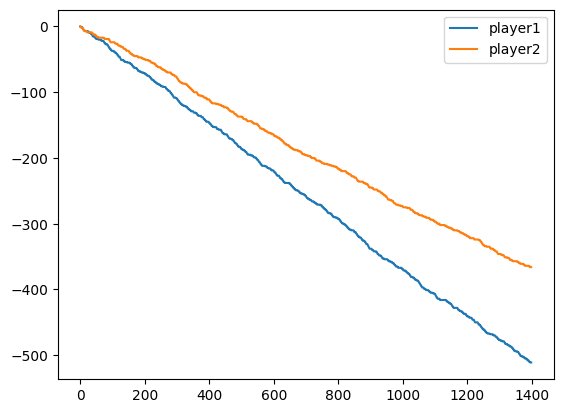

In [29]:
#@title Case - Optimal vs DRL
policy = MultiAgentPolicyManager([OptimalPolicy(), agent_learn2],  _get_env())
test_envs = DummyVectorEnv([_get_env for _ in range(2)])
test_collector = Collector(policy, test_envs, exploration_noise=True)

result = test_collector.collect(n_step=4*1000)
arr = result["rews"]
death_rates = np.sum(arr, axis=0) / np.sum(arr, axis=0)[0]
print(f"death rate of player2: {(np.sum(arr, axis=0) / arr.shape[0])[-1] * -1:.3f}")
print(f"ratio of death rate of player2 with respect to player1: {death_rates[-1]:.3f}")
plt.plot(arr.cumsum(axis=0))
plt.legend(("player1", "player2"))
plt.show()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


death rate of player2: 0.188
ratio of death rate of player2 with respect to player1: 0.587


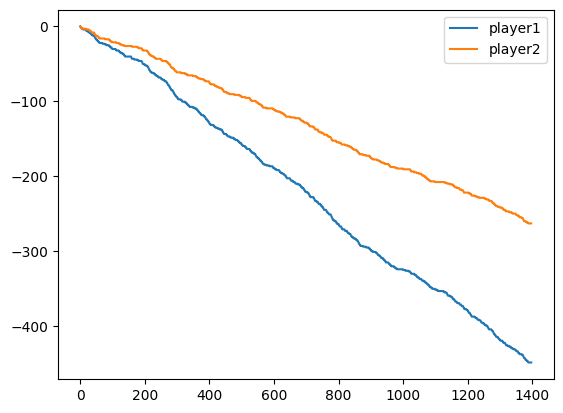

In [30]:
#@title Case - optimal vs optimal
policy = MultiAgentPolicyManager([OptimalPolicy(), OptimalPolicy()],  _get_env())
test_envs = DummyVectorEnv([_get_env for _ in range(2)])
test_collector = Collector(policy, test_envs, exploration_noise=True)

result = test_collector.collect(n_step=4*1000)
arr = result["rews"]
death_rates = np.sum(arr, axis=0) / np.sum(arr, axis=0)[0]
print(f"death rate of player2: {(np.sum(arr, axis=0) / arr.shape[0])[-1] * -1:.3f}")
print(f"ratio of death rate of player2 with respect to player1: {death_rates[-1]:.3f}")
plt.plot(arr.cumsum(axis=0))
plt.legend(("player1", "player2"))
plt.show()